# TASK VII: Equivariant Quantum Neural Network

In this task you are supposed to get started with equivariant quantum neural networks by implementing a $\mathbb{Z}_2 \times \mathbb{Z}_2$ equivariant quantum neural network. $\mathbb{Z}_2$ is a symmetry group an as an example we will generate a simple classical dataset which is respects the $\mathbb{Z}_2 \times \mathbb{Z}_2$ symmetry.


This example is explained in the paper https://arxiv.org/abs/2205.06217 and additional background can be found in https://arxiv.org/abs/2210.08566.


Generate a classification dataset with two classes and two features $x_1$ and $x_2$ which respects the $\mathbb{Z}_2 \times \mathbb{Z}_2$ symmetry (this corresponds to mirroring along $y=x$). An example can be found in the first reference paper.


Train a QNN to solve the classification problem
Train an $\mathbb{Z}_2\times \mathbb{Z}_2$ equivariant QNN to solve the classification problem and compare the results.


In [14]:
%%capture
pip install pennylane

In [15]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer

import matplotlib.pyplot as plt
from matplotlib import colors

## 0.-Generate Data


**Symmetries in $\mathbb{Z}_2 \times \mathbb{Z}_2$**

We will use the following dataset for a classification problem with two features $(x_1, x_2)$. This dataset has a $\mathbb{Z}_2 \times \mathbb{Z}_2 $ symmetry, which corresponds with the following symmetries:

$$y(x_1, x_2) = y(x_2, x_1) = y(-x_1, -x_2) $$


This corresponds to an exchange of the coordinates and a simultaneous sign flip. The associated symmetry group, famously known as Klein's four-group, is given by:

$$\mathbb{Z}_2 \times \mathbb{\mathbb{Z}}_2 = \{(0,0), (1,0), (0,1), (1,1)\}$$

The first component could be understood as the boolean answer to the question "do we exchange?" and the second component as the boolean answer to the question "do we flip?"




**Representation**


The representation on the level of the data is given by:


$$V_{(0,0)} =\begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix}, \quad \quad V_{(1,0)} = \begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix} $$


$$V_{(0,1)} =\begin{pmatrix} -1 & 0 \\ 0 & -1 \end{pmatrix}, \quad \quad V_{(1,1)} = \begin{pmatrix} 0 & -1 \\ -1 & 0 \end{pmatrix} $$


If we use an embedding unitary:


$$ U(x_1, x_2) = R_Z(x_1) \otimes R_Z(x_2)$$

Then the symmetry operations can be represented on the level of the Hilbert space as:


\begin{equation} U(x_2, x_1) = R_Z(x_2) \otimes R_Z(x_1) = SWAP\,\,  U(x_1,x_2) \,\, SWAP \end{equation}

\begin{equation} U(-x_1, -x_2) = R_Z(-x_1) \otimes R_Z(-x_2) = (X \otimes X) U(x_1, x_2) (X \otimes X) \end{equation}


where $XZX = -Z$.



We call a data encoding unitary $U(x)$ equivariant with respect to the data symmetry $V_s$ if

\begin{equation} U(V_s[x]) = U_s U(x)U_s^{\dagger} \end{equation}



The representation induced by our above example is then:

\begin{align}
U_{(0,0)} &= \mathbb{I} \otimes \mathbb{I}, \quad \quad &\text{identity}\\
U_{(1,0)} &= SWAP, \quad \quad  &\text{exchange } \leftrightarrow \\
U_{(0,1)} &= X \otimes X, \quad \quad &\text{sign flip } \pm \\
U_{(1,1)} &= SWAP(X \otimes X), \quad \quad &\text{exchange and sign flip} \leftrightarrow, \pm.
\end{align}



**From general Ansatz to equivariant ansatz**


We can now use the aforementioned gate symmetrization technique to convert a complete ansatz (or trainable block) to an equivariant ansatz (or equivariant trainable block) by replacing the ansatz' gateset with its equivariant counterpart.

The ansatz is made up of local rotation gates generated by the Pauli operators, $\{X,Y,Z\}$, and entangling gates generated by a ZZ interaction, all of which we consider as trainable. In this case, the gateset is:
$$G = \{X_1, Y_1,Z_1,X_2,Y_2,Z_2,Z_1Z_2\}$$

where the index identifies the qubit the Pauli is acting on. The $R_{ZZ}$ gate already commutes with the swap operation, which means we can focus on the local operations only.


The symmetry group $\mathbb{Z}_2 \times \mathbb{Z}_2$
, has the symmetries were generated by SWAP (exchange
$\leftrightarrow$) and $X\otimes X =
X_1X_2$ (sign flip $\pm$).

So, we have to ensure that the Ansatzs be equivariant for both symmetries:

1. Exchange symmetry $↔$:

The generator $Z_1 Z_2$ already commutes with the swap operations and thus stays invariant under symmetrization. Also, the gateset equivariant with respect to the exchange symmetry is then given by symmetric entangling gates and simultaneous Pauli rotations on the two qubits that share the same angle:

$$G_{↔} = \left\{\frac{X_1+X_2}{2}, \frac{Y_1+Y_2}{2}, \frac{Z_1+Z_2}{2}, Z_1 Z_2  \right\}$$


2. Sign flip symmetry $\pm$:

Again, $Z_1Z_2$ already commutes with $X_1X_2$ and stays invariant under symmetrization. The situation is again different for the local gates. It is quite straightforward that $X_1$ and $X_2$ commute with $X_1X_2$ because $X(X)X = X$ but this is not true for the other gates due to $XYX = -Y$ and $XZX=-Z$.

This means that in the sign flip equivariant gateset we have only allowed local Pauli X rotations:

$$G_{\pm} = \{X_1, X_2, Z_1Z_2 \}$$




Due to the commuting nature of the group, we can obtain the **fully equivariant gateset** by applying either symmetrization procedure to the other gateset which yields:

$$G_{\leftrightarrow, \pm} = \left\{ \frac{X_1+X_2}{2}, Z_1Z_2 \right\}  \quad \quad \quad (1)$$



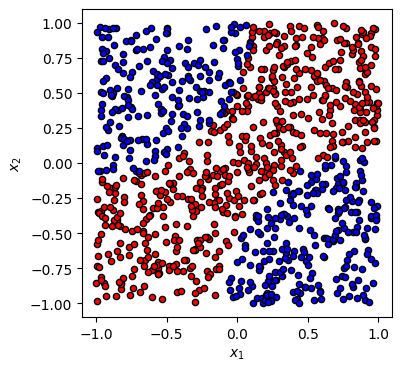

In [40]:
def Data_generate(samples, center=[[-1.0, 1.0],[1.0, -1.0]], radius=1.1):
    """
    Generates a dataset of points with 1/0 labels.

    Args:
        samples (int): number of samples to generate
        center (list): coordinates of the centers of the classes
        radius (float): radius of the classification boundary

    Returns:
        Xvals (array): coordinates of points
        yvals (array): classification labels
    """
    Xvals, yvals = [], []

    for i in range(samples):
        x = 2 * (np.random.rand(2)) - 1
        y = 0
        if np.linalg.norm(x - center[0]) < radius or np.linalg.norm(x - center[1]) < radius:
            y = 1
        Xvals.append(x)
        yvals.append(y)
    return np.array(Xvals, requires_grad=False), np.array(yvals, requires_grad=False)

def plot_data(x, y, fig=None, ax=None):
    """
    Plot data with red/blue values for a binary classification.

    Args:
        x (array[tuple]): array of data points as tuples
        y (array[int]): array of data points as tuples
    """
    if fig == None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    reds = y == 0
    blues = y == 1
    ax.scatter(x[reds, 0], x[reds, 1], c="red", s=20, edgecolor="k")
    ax.scatter(x[blues, 0], x[blues, 1], c="blue", s=20, edgecolor="k")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")



Xdata, ydata = Data_generate(1000)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_data(Xdata, ydata, fig=fig, ax=ax)
plt.show()

## 1.-Simple QNN classifier with data reloading and fidelity loss


For this quantum neural network, we will employ the data-reuploading model [4] with one qubit structured as follows:


* $Rot( [x_1, x_2, 0])$

* $Rot( [\phi, \theta, \omega])$

with the Rot function* defined as:
 $$Rot(\phi, \theta, \omega) = RZ(\phi) RY(\theta) RZ(\omega)$$

We utilize three layers, Adam optimization, and the loss function given by:

 $$L_{QNN} = (1-f)^2$$



The observables $O_1$ and $O_2$ are defined as:

$$ O_1 = \begin{pmatrix} 1 & 0 \\ 0 & 0 \end{pmatrix}, \quad \quad \text{and} \quad \quad O_2 = \begin{pmatrix} 0 & 0 \\ 0 & 1 \end{pmatrix} $$



*https://docs.pennylane.ai/en/stable/code/api/pennylane.Rot.html





In [41]:

dev = qml.device("lightning.qubit", wires=1)

@qml.qnode(dev)
def qcircuit(params, x, y):
    """A variational quantum circuit representing the Universal classifier.

    Args:
        params (array[float]): array of parameters
        x (array[float]): single input vector
        y (array[float]): single output state density matrix

    Returns:
        float: fidelity between output state and input
    """
    for p in params:
        qml.Rot(*x, wires=0)
        qml.Rot(*p, wires=0)
    return qml.expval(qml.Hermitian(y, wires=[0]))


### Utility functions

In [42]:

# Define output labels as quantum state vectors
def density_matrix(state):
    """Calculates the density matrix representation of a state.

    Args:
        state (array[complex]): array representing a quantum state vector

    Returns:
        dm: (array[complex]): array representing the density matrix
    """
    return state * np.conj(state).T


def cost(params, x, y, state_labels=None):
    """Cost function to be minimized.

    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): array of state representations for labels

    Returns:
        float: loss value to be minimized
    """
    # Compute prediction for each input in data batch
    loss = 0.0
    dm_labels = [density_matrix(s) for s in state_labels]
    for i in range(len(x)):
        f = qcircuit(params, x[i], dm_labels[y[i]])
        loss = loss + (1 - f) ** 2
    return loss / len(x)


def test(params, x, y, state_labels=None):
    """
    Tests on a given set of data.

    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        predicted (array([int]): predicted labels for test data
        output_states (array[float]): output quantum states from the circuit
    """
    fidelity_values = []
    dm_labels = [density_matrix(s) for s in state_labels]
    predicted = []

    for i in range(len(x)):
        fidel_function = lambda y: qcircuit(params, x[i], y)
        fidelities = [fidel_function(dm) for dm in dm_labels]
        best_fidel = np.argmax(fidelities)

        predicted.append(best_fidel)
        fidelity_values.append(fidelities)

    return np.array(predicted), np.array(fidelity_values)



def accuracy_score(y_true, y_pred):
    """Accuracy score.

    Args:
        y_true (array[float]): 1-d array of targets
        y_predicted (array[float]): 1-d array of predictions
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        score (float): the fraction of correctly classified samples
    """
    score = y_true == y_pred
    return score.sum() / len(y_true)



def iterate_minibatches(inputs, targets, batch_size):
    """
    A generator for batches of the input data

    Args:
        inputs (array[float]): input data
        targets (array[float]): targets

    Returns:
        inputs (array[float]): one batch of input data of length `batch_size`
        targets (array[float]): one batch of targets of length `batch_size`
    """
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

### Training QNN

In [19]:
num_training = 200
num_test = 2000

label_0 = [[1], [0]]
label_1 = [[0], [1]]
state_labels = np.array([label_0, label_1], requires_grad=False)


Xdata, y_train = Data_generate(num_training)
X_train = np.hstack((Xdata, np.zeros((Xdata.shape[0], 1), requires_grad=False)))

Xtest, y_test = Data_generate(num_test)
X_test = np.hstack((Xtest, np.zeros((Xtest.shape[0], 1), requires_grad=False)))


# Train using Adam optimizer and evaluate the classifier
num_layers = 3
learning_rate = 0.1
epochs = 15
batch_size = 32

opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

# initialize random weights
params = np.random.uniform(size=(num_layers, 3), requires_grad=True)

predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
accuracy_test = accuracy_score(y_test, predicted_test)


# save predictions with random weights for comparison
initial_predictions = predicted_test


loss = cost(params, X_test, y_test, state_labels)

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)


best_val_accuracy = accuracy_test
best_params = params.copy()

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
        params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, state_labels)

    predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss = cost(params, X_train, y_train, state_labels)

    predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)
    if accuracy_test > best_val_accuracy:
        best_params = params.copy()
        best_val_accuracy = accuracy_test
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )

Epoch:  0 | Cost: 0.297908 | Train accuracy: 0.515000 | Test Accuracy: 0.556000
Epoch:  1 | Loss: 0.217628 | Train accuracy: 0.670000 | Test accuracy: 0.697000
Epoch:  2 | Loss: 0.128548 | Train accuracy: 0.865000 | Test accuracy: 0.870500
Epoch:  3 | Loss: 0.130013 | Train accuracy: 0.850000 | Test accuracy: 0.817500
Epoch:  4 | Loss: 0.125796 | Train accuracy: 0.850000 | Test accuracy: 0.835500
Epoch:  5 | Loss: 0.111727 | Train accuracy: 0.875000 | Test accuracy: 0.872500
Epoch:  6 | Loss: 0.109892 | Train accuracy: 0.865000 | Test accuracy: 0.875500
Epoch:  7 | Loss: 0.106007 | Train accuracy: 0.875000 | Test accuracy: 0.891500
Epoch:  8 | Loss: 0.103979 | Train accuracy: 0.875000 | Test accuracy: 0.883500
Epoch:  9 | Loss: 0.103042 | Train accuracy: 0.865000 | Test accuracy: 0.870500
Epoch: 10 | Loss: 0.102224 | Train accuracy: 0.860000 | Test accuracy: 0.872000
Epoch: 11 | Loss: 0.101678 | Train accuracy: 0.865000 | Test accuracy: 0.878000
Epoch: 12 | Loss: 0.101615 | Train accur

### Visualization

Cost: 0.101054 | Train accuracy 0.860000 | Test Accuracy : 0.875500
Learned weights
Layer 0: [ 1.27805079 -0.45441804 -1.1223713 ]
Layer 1: [ 0.53909803  0.2811599  -0.80431584]
Layer 2: [1.6858187  1.26101767 0.38225492]


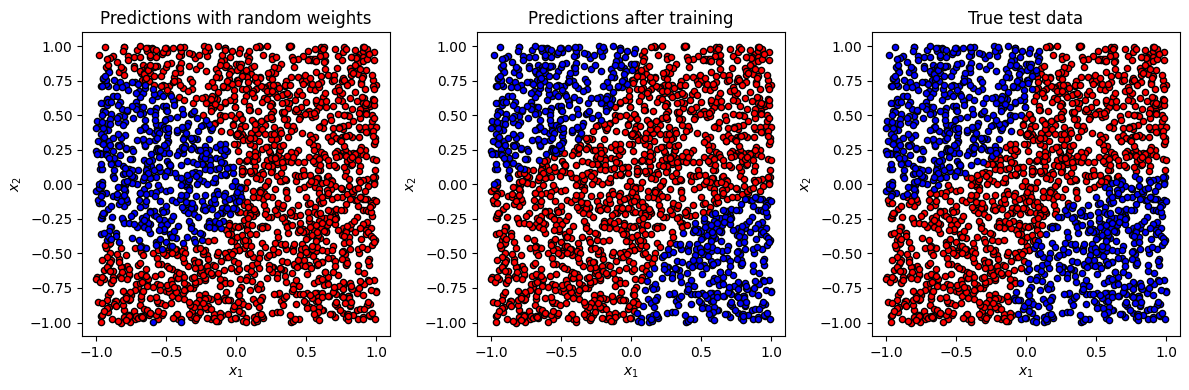

In [20]:
print(
    "Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(
        loss, accuracy_train, accuracy_test
    )
)

print("Learned weights")
for i in range(num_layers):
    print("Layer {}: {}".format(i, params[i]))


fig, axes = plt.subplots(1, 3, figsize=(12, 4))
plot_data(X_test, initial_predictions, fig, axes[0])
plot_data(X_test, predicted_test, fig, axes[1])
plot_data(X_test, y_test, fig, axes[2])
axes[0].set_title("Predictions with random weights")
axes[1].set_title("Predictions after training")
axes[2].set_title("True test data")
plt.tight_layout()
plt.show()

The implemented quantum circuit utilizes a single-wire quantum device. The qcircuit function takes three arguments: params, x, and y. The params are a matrix of parameters used within the rotational gates in the circuit. x represents an individual input vector, and y represents a label.

Within the circuit, several rotational operations are performed. In each iteration of the for loop, a Rotational gate is applied first with the angles encoded in x, and then with the rotation parameters in params. This sequence of Rotational gates is repeated for each set of parameters in params.

At the end of the circuit, the expectation value is calculated using a Hermitian observable applied to the quantum wire. This provides a quantitative measure of the similarity between the output state of the circuit and the target state density matrix associated with y.

(<Figure size 900x200 with 1 Axes>, <Axes: >)

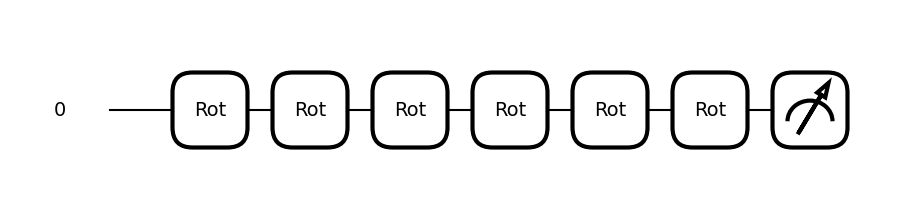

In [21]:
qml.draw_mpl(qcircuit)(params, X_train[0], density_matrix(state_labels[0]))

In [22]:
print(qml.draw(qcircuit)(params, X_train[0], density_matrix(state_labels[0])))

0: ──Rot(-0.95,-0.86,0.00)──Rot(1.28,-0.45,-1.12)──Rot(-0.95,-0.86,0.00)──Rot(0.54,0.28,-0.80)

───Rot(-0.95,-0.86,0.00)──Rot(1.69,1.26,0.38)─┤  <𝓗(M0)>

M0 = 
[[1 0]
 [0 0]]


## 2.-Equivariant QNN

For the equivariant Quantum Neural Network (EQNN), I adopt the quantum circuit structure outlined in reference [3]. This involves a circuit with 2 qubits organized as follows:

First, we initialize the states and apply angle embedding:
* Hadamard gate in each qubit
* $RZ(x_1)$ in first qubit
* $RZ(x_2)$ in first qubit


Then, we construct the ansatz:
* $RX(\theta_1)$ in second qubit
* $RX(\theta_1)$ in second qubit
* $RZZ(\theta_2)$ in second qubit

This structure is constructed with the gates from the equivariant gateset (1), indicating that this Ansatz is equivariant.

The Ansatz is applied for 5 layers, and we utilize the same optimizer and loss function.

The observable is given by:

$$O = \frac{1}{4} \begin{pmatrix}
1 & 1 & 1 & 1 \\
1 & 1 & 1 & 1 \\
1 & 1 & 1 & 1 \\
1 & 1 & 1 & 1
 \end{pmatrix}$$




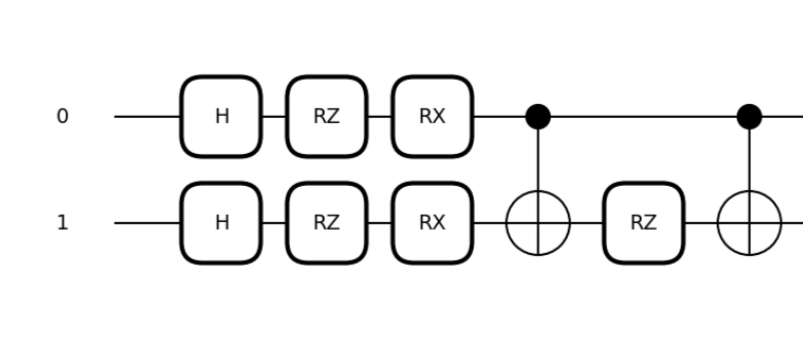

In [54]:
dev = qml.device("default.qubit", wires=2)

#the observables now have to be invariant under SWAP and X gates

label_0 = [[1], [1],[1], [1]]
label_1 = [[1], [-1],[-1], [1]]
state_labels = np.array([label_0, label_1], requires_grad=False)/2


@qml.qnode(dev, interface="autograd")
def qcircuit(params, x, y):
    # prepare initial state in a invariant state
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    for p in params:
        #embedding
        qml.RZ(x[0], wires=0)
        qml.RZ(x[1], wires=1)

        #Since exp(X_1+X_2) = RX_1 \cross RX_2
        qml.RX(p[0], wires=0)
        qml.RX(p[0], wires=1)

        #Rzz gates
        qml.CNOT([0,1])
        qml.RZ(p[1], wires=1)
        qml.CNOT([0,1])

    return qml.expval(qml.Hermitian(y, wires=[0,1]))

In [55]:
num_training = 200
num_test = 1000

Xdata, y_train = Data_generate(num_training)
X_train = Xdata
y_train = y_train

Xtest, y_test = Data_generate(num_test)
X_test = Xtest

# # Train using Adam optimizer and evaluate the classifier
num_layers = 5
learning_rate = 0.01
epochs = 5
batch_size = 32


# # initialize random weights
params = np.random.uniform(size=(num_layers, 2), requires_grad=True)
initial_predictions, initial_fidel = test( params, X_test, y_test, state_labels)

#best_params = np.load('best_params_eqnn.npy')
#best_params1 = np.load("/content/best_params_eqnn.npy")
#params = best_params1

opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
accuracy_test = accuracy_score(y_test, predicted_test)
loss = cost(params, X_test, y_test, state_labels)

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)
best_val_accuracy = accuracy_test
best_params = params.copy()

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
        params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, state_labels)

    predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss = cost(params, X_train, y_train, state_labels)

    predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)

    if accuracy_test > best_val_accuracy:
        best_params = params.copy()
        best_val_accuracy = accuracy_test
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )

Epoch:  0 | Cost: 0.560030 | Train accuracy: 0.545000 | Test Accuracy: 0.607000
Epoch:  1 | Loss: 0.537010 | Train accuracy: 0.570000 | Test accuracy: 0.627000
Epoch:  2 | Loss: 0.487754 | Train accuracy: 0.600000 | Test accuracy: 0.651000
Epoch:  3 | Loss: 0.437633 | Train accuracy: 0.665000 | Test accuracy: 0.687000
Epoch:  4 | Loss: 0.391189 | Train accuracy: 0.700000 | Test accuracy: 0.742000
Epoch:  5 | Loss: 0.352204 | Train accuracy: 0.775000 | Test accuracy: 0.818000


In [56]:
#np.save("best_params_1.npy", best_params)

Cost: 0.352204 | Train accuracy 0.775000 | Test Accuracy : 0.818000
Learned weights
Layer 0: [0.64731944 0.55788679]
Layer 1: [0.83739557 0.47359907]
Layer 2: [0.46344247 0.84723306]
Layer 3: [0.745539   0.76964761]
Layer 4: [0.04060852 0.63266258]


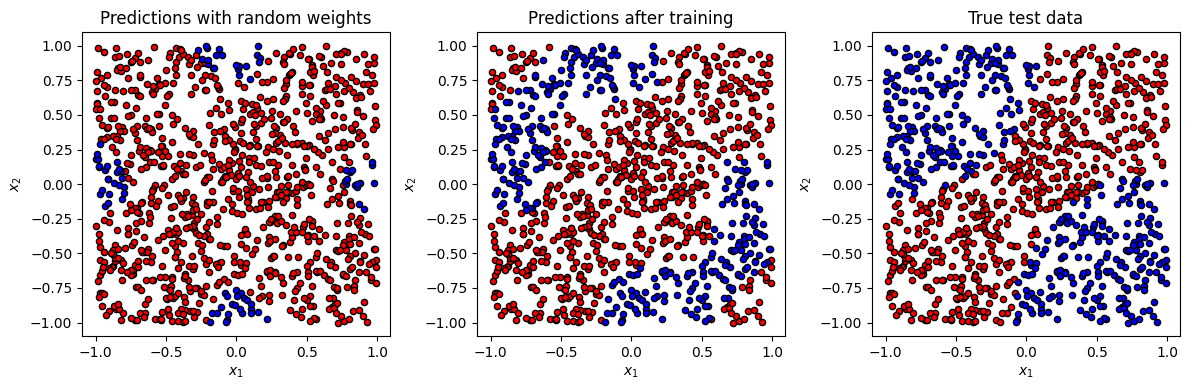

In [57]:
print(
    "Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(
        loss, accuracy_train, accuracy_test
    )
)

print("Learned weights")
for i, p in enumerate(params):
    print("Layer {}: {}".format(i, p))


fig, axes = plt.subplots(1, 3, figsize=(12, 4))
plot_data(X_test, initial_predictions, fig, axes[0])
plot_data(X_test, predicted_test, fig, axes[1])
plot_data(X_test, y_test, fig, axes[2])
axes[0].set_title("Predictions with random weights")
axes[1].set_title("Predictions after training")
axes[2].set_title("True test data")
plt.tight_layout()
plt.show()

(<Figure size 2900x300 with 1 Axes>, <Axes: >)

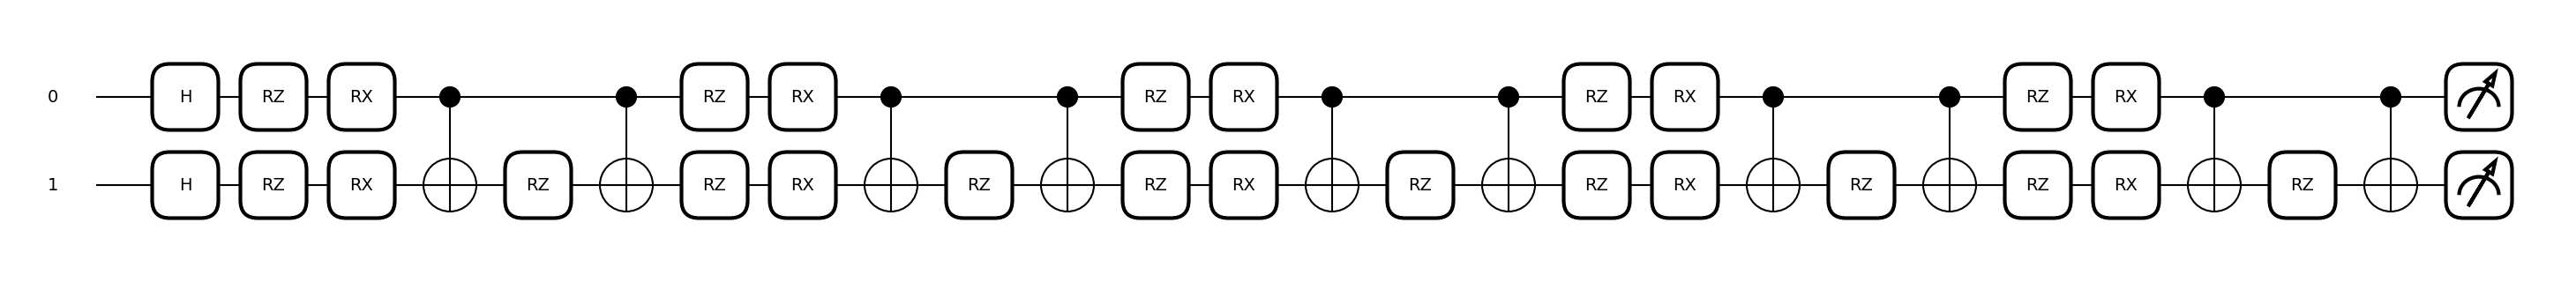

In [58]:
qml.draw_mpl(qcircuit)(params, X_train[0], density_matrix(state_labels[0]))

In [59]:
print(qml.draw(qcircuit)(params, X_train[0], density_matrix(state_labels[0])))

0: ──H──RZ(-0.26)──RX(0.65)─╭●───────────╭●──RZ(-0.26)──RX(0.84)─╭●───────────╭●──RZ(-0.26)
1: ──H──RZ(0.29)───RX(0.65)─╰X──RZ(0.56)─╰X──RZ(0.29)───RX(0.84)─╰X──RZ(0.47)─╰X──RZ(0.29)─

───RX(0.46)─╭●───────────╭●──RZ(-0.26)──RX(0.75)─╭●───────────╭●──RZ(-0.26)──RX(0.04)─╭●──────────
───RX(0.46)─╰X──RZ(0.85)─╰X──RZ(0.29)───RX(0.75)─╰X──RZ(0.77)─╰X──RZ(0.29)───RX(0.04)─╰X──RZ(0.63)

──╭●─┤ ╭<𝓗(M0)>
──╰X─┤ ╰<𝓗(M0)>

M0 = 
[[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]


### To demonstrate preservation of input symmetry

We are testing the circuit to demonstrate that the equivariant model accounts for the input order.


This means that the output differs even if the input is the same, considering the order of values.
For instance:
- T1: Original point (x1, x2)
- T2: Transformed from (x1, x2) to (-x1, -x2)
- T3: Position change from (x1, x2) to (x2, x1)

In [68]:
D = density_matrix(state_labels[0])

#we evaluate the quantum circuit in each input with differences in the order
T1 = qcircuit(params,X_test[0] ,D)
T2 = qcircuit(params,-X_test[0] ,D)
T3 = qcircuit(params,X_test[0, [1,0]] ,D)

print(T1 == T2, T1 == T3)

False False


Let's look the output of each input

In [69]:
T1

tensor(0.27716617, requires_grad=True)

In [70]:
T2

tensor(0.27716617, requires_grad=True)

In [71]:
T3

tensor(0.27716617, requires_grad=True)

All the outputs have the same value but they are different, with this result, we check that the model considers the input order.

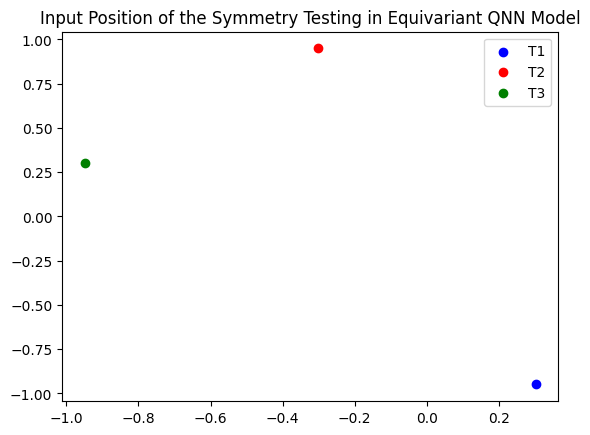

In [72]:
plt.scatter(X_test[0][0], X_test[0][1], color = "b", label = "T1")  #this is the original point (x1,x2)
plt.scatter(-X_test[0][0], -X_test[0][1], color = "r", label = "T2") #this is from (x1,x2) ----> (-x1, -x2)
plt.scatter(X_test[0][1], X_test[0][0], color = "g", label = "T3")  #this change the position (x1, x2) ---> (x2,x1)
plt.title("Input Position of the Symmetry Testing in Equivariant QNN Model")
plt.legend()
plt.show()

### References:


[1] [Quynh T. Nguyen et al. "Theory for Equivariant Quantum Neural Networks." arXiv:2210.08566, Oct, 2022.](https://arxiv.org/abs/2210.08566)

[2] [Johannes Jakob Meyer et al. "Exploiting symmetry in variational quantum machine learning." arXiv:2205.06217, May, 2022.](https://arxiv.org/abs/2205.06217)



[3] [Zhongtian Dong, Marçal Comajoan Cara,, Gopal Ramesh Dahale, Roy T. Forestano,
Sergei Gleyzer, Daniel Justice, Kyoungchul Kong, Tom Magorsch, Konstantin T. Matchev, Katia Matcheva and Eyup B. Unlu. "Z2 × Z2 Equivariant Quantum Neural Networks: Benchmarking against Classical Neural Networks." Mar, 2024.](https://arxiv.org/pdf/2311.18744.pdf)


[4] [Ahmed, Shahnawaz. "Data-reuploading classifier." PennyLane Demos, Oct, 2019.](https://pennylane.ai/qml/demos/tutorial_data_reuploading_classifier/#talk-is-cheap-show-me-the-code-linus-torvalds)


[5] [Pérez-Salinas, Adrián, et al. “Data re-uploading for a universal quantum classifier.” arXiv preprint arXiv:1907.02085 (2019).](https://arxiv.org/abs/1907.02085)

